<a href="https://colab.research.google.com/github/Huangliang0826/DataAnalysis/blob/master/Bunq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Bunq Data Science Intern Assignment

Author: Liang Huang. 
Date: 14 March 2019.
Email: liang.huang@student.uva.nl

## Objective: 

### 1. Find an optimal credit assignment given a finite budget.
### 2. Maximize the combined ROI (Return of Investment) of the individual campaigns.

## My Approach: 

### 1. Clean the input data. (Data corruption from row 763 to raw 1144).
### 2. Visualize the covariance among features.
### 3. Feature engineering and build the learning model. (Decision Tree, SVM, K-arm bandit)
### 4. Analysis of the results and select the best performing model.
### 5. Bring it to production.


### Import the libraries.

In [0]:
import numpy as np
import random
import math
from itertools import *
from scipy.stats import norm
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
plt.style.use('default')


# SK-Learn libraries
from sklearn import svm
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

## 1.1 Imported the cleaned data, display some samples.

#### 1. The data is corrupted from row 763 to row 1144, I correct the data by shifting some features two columns to the right, which leads to the campaign_id and fb_campaign_id  data are missing for row 763 to row 1144. 

#### 2. Since the campaign_id and fb_campaign_id don't matter much for our biding model, so I ignored these two features for the training process.


In [0]:
# Imported the cleaned data.
data_url = 'https://raw.githubusercontent.com/Huangliang0826/DataAnalysis/master/data.csv'
data = pd.read_csv(data_url)

# Display first five entries.
data.head()

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,17/08/2017,17/08/2017,916.0,103916.0,30-34,M,15,17,17,7350,1,1.43,2,1
1,708749,17/08/2017,17/08/2017,916.0,103917.0,30-34,M,16,19,21,17861,2,1.82,2,0
2,708771,17/08/2017,17/08/2017,916.0,103920.0,30-34,M,20,25,22,693,0,0.00,1,0
3,708815,30/08/2017,30/08/2017,916.0,103928.0,30-34,M,28,32,32,4259,1,1.25,1,0
4,708818,17/08/2017,17/08/2017,916.0,103928.0,30-34,M,28,33,32,4133,1,1.29,1,1


## 1.2 Choose useful features, formalize the feature values.
#### 1. Currently, we have 15 columns of data; not all columns are helpful for this task. I choose some features that can directly affect our campaign performance.
#### 2. Some features are numbers; some are strings. To formalize the feature values, I need to convert the string to numbers. For example, for gender features: Male can convert to 0, Female can convert to 1. For the age values, we transfer the age interval to the mean value of age interval. (e.g. 30-34 => 32, 35-39=>37)
#### 3. Add new Column: approved_conversion/spent. Because our main objective is to maximize the number of approved_conversion and minimize our spent, then the approved_conversion/spent can be a good indicator to measure our ROI(Return of Investment). 


In [0]:
# Clean the dataframe.
data = data.loc[:,['gender','age','interest1','interest2','interest3','impressions','clicks','spent','total_conversion','approved_conversion']]

# Formalise the gender feature values: Male ->0, Female -> 1.
data.loc[data.gender == 'M', 'gender'] = 0 
data.loc[data.gender == 'F', 'gender'] = 1 

# Formalise the age values to the mean value of the interval: 30-34 => 32, 35-39=> 37.
data["age"] = (data.age.str.split('-').str[0].astype(float) + data.age.str.split('-').str[1].astype(float))/2

# Add new Column: approved_conversion/spent.
# To avoid dividing by 0, we just set approv_conv/spent equal 0 when spent is 0
data.loc[data.spent > 0, "approv_conv/spent"] = (data["approved_conversion"])/(data["spent"])
data.loc[data.spent ==0, "approv_conv/spent"] = 0

## 1.3 Generate descriptive statistics that summarize the dataset and show dataset's distribution.

In [0]:
# Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

data.describe()


,gender,age,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion,approv_conv/spent
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,0.482065,38.321085,32.766404,36.245844,36.222222,1.867321e+05,33.390201,51.360656,2.855643,0.944007,0.069602
std,0.499897,5.903868,26.952131,26.937853,26.924679,3.127622e+05,56.892438,86.908418,4.483593,1.737708,0.244452
min,0.000000,32.000000,2.000000,3.000000,3.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,32.000000,16.000000,20.000000,20.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000,0.000000
50%,0.000000,37.000000,25.000000,28.000000,28.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000,0.000000
75%,1.000000,42.000000,31.000000,35.000000,35.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000,0.028253
max,1.000000,47.000000,114.000000,118.000000,120.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000,5.555555


### 1.3.1 Here are some interesting facts we can see from the above statistics:

#### 1. The mean value of gender is 0.482, which means there are 3.6% more males than females in this dataset. Female (48.2%), Male(51.8%). The dataset is roughly balanced in the gender category. (which may not be correct, since some people appear more than once in the dataset. Need further analysis.)
#### 2. The average approved_conversion/spent rate is 0.0696, which means we normally spend 14.37 for one approved conversion. This can be a good indicator if we want to measure the performance of our bidding model.


## 2.Build the learning model: Classification or Regression?

#### Our primary objective is to find the optimal assignment given the finite budget. Therefore, there are at least two approaches to solve this problem: one approach is to build a regression model to predict the approv_conv/spent rate based on the user's profiles (gender, age, interests); another approach is to create a classification model to classify the target users based on user's profiles. In this section, I am going to implement both the regression model and the classification model with different algorithms and choose the best algorithms for each model.



## 2.1 Process the data: normalise the dataset, randomly split it into training dataset (80%) and test dataset(20%).

In [0]:
# Normalise the entire dataset.
normalizer = MinMaxScaler()
normalizer.fit(data)

normalised_data = pd.DataFrame(normalizer.transform(data),
                       columns = data.keys(),
                       index = data.index)

input_features = normalised_data[["age", "gender", "interest1", "interest2", "interest3"]]

output_labels = normalised_data[["approv_conv/spent"]]

x_train, x_test, y_train, y_test = train_test_split(input_features, output_labels, test_size=0.2, random_state=42)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
# Generate descriptive statistics that summarize the dataset
normalised_data.describe()

,gender,age,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion,approv_conv/spent
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,0.482065,0.421406,0.274700,0.289094,0.283951,0.061157,0.079312,0.080257,0.047594,0.044953,0.012528
std,0.499897,0.393591,0.240644,0.234242,0.230125,0.102481,0.135136,0.135805,0.074727,0.082748,0.044001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.125000,0.147826,0.145299,0.002102,0.002375,0.002313,0.016667,0.000000,0.000000
50%,0.000000,0.333333,0.205357,0.217391,0.213675,0.016849,0.019002,0.019330,0.016667,0.047619,0.000000
75%,1.000000,0.666667,0.258929,0.278261,0.273504,0.072637,0.089074,0.093796,0.050000,0.047619,0.005086
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.2 Generate convariance matrix of features.

In [0]:
normalised_data.cov()

,gender,age,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion,approv_conv/spent
gender,0.249897,0.011797,0.005682,0.005502,0.005034,0.003435,0.011398,0.008488,0.001029,-0.001049,-0.000918
age,0.011797,0.154914,0.004140,0.003939,0.003961,0.004082,0.011005,0.010184,-0.001958,-0.002684,-0.000644
interest1,0.005682,0.004140,0.057910,0.056251,0.055270,0.002515,0.002885,0.002295,0.002163,0.001162,-0.000100
interest2,0.005502,0.003939,0.056251,0.054869,0.053694,0.002436,0.002785,0.002216,0.002084,0.001146,-0.000096
interest3,0.005034,0.003961,0.055270,0.053694,0.052958,0.002407,0.002766,0.002200,0.002075,0.001116,-0.000076
impressions,0.003435,0.004082,0.002515,0.002436,0.002407,0.010502,0.013136,0.013505,0.006225,0.005802,-0.000549
clicks,0.011398,0.011005,0.002885,0.002785,0.002766,0.013136,0.018262,0.018222,0.007015,0.006257,-0.000749
spent,0.008488,0.010184,0.002295,0.002216,0.002200,0.013505,0.018222,0.018443,0.007361,0.006666,-0.000759
total_conversion,0.001029,-0.001958,0.002163,0.002084,0.002075,0.006225,0.007015,0.007361,0.005584,0.005343,-0.000198
approved_conversion,-0.001049,-0.002684,0.001162,0.001146,0.001116,0.005802,0.006257,0.006666,0.005343,0.006847,0.000223


## 2.3 Define a collection of Regression Models

In [0]:
# Define the random state for AdaBoost.
rng = np.random.RandomState(1)

# Define kernels for Gaussian Process.
kernel = ExpSineSquared(10.0, 10.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)

# Fit models.
ESTIMATORS = {"LinearRegression": LinearRegression(), 
         "RidgeCV": linear_model.RidgeCV(alphas=[0.3, 2.0, 10.0], cv=3),
         "SVM_Regression": svm.SVR(),
         "AdaBoost":AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng),
         "GaussianProcess":GaussianProcessRegressor(kernel=kernel,
          random_state=0)
        }

# Convert y_test to numpy vector.
y_label = y_test.values.transpose()
y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(x_train, y_train.values.ravel())
    y_test_predict[name] = estimator.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## 2.4 Comparing different regression models and choose the best one.

In [0]:
# Compare different models.
estimator_score = []
estimator_loss = []
for e in ESTIMATORS:
    y_pred = ESTIMATORS[e].predict(x_test)
    y_pred = y_test_predict[e]
    Loss = np.sum((y_pred.reshape(y_label.shape[0],y_label.shape[1]) - y_label)**2,axis=1)/len(y_test)
    estimator_score.append(ESTIMATORS[e].score(x_test, y_test))
    estimator_loss.append(Loss[0])
    print("ESTIMATORS:", e)
    print("Score:", ESTIMATORS[e].score(x_test, y_test))
    print(f"Loss: {Loss}")
    print("***********************************************")

ESTIMATORS: LinearRegression
Score: -0.015746121997658236
Loss: [0.00183166]
***********************************************
ESTIMATORS: RidgeCV
Score: -0.01566898903949343
Loss: [0.00183152]
***********************************************
ESTIMATORS: SVM_Regression
Score: -3.914872947329581
Loss: [0.00886281]
***********************************************
ESTIMATORS: AdaBoost
Score: -0.49833751500105555
Loss: [0.0027019]
***********************************************
ESTIMATORS: GaussianProcess
Score: -0.010546196958005405
Loss: [0.00182228]
***********************************************


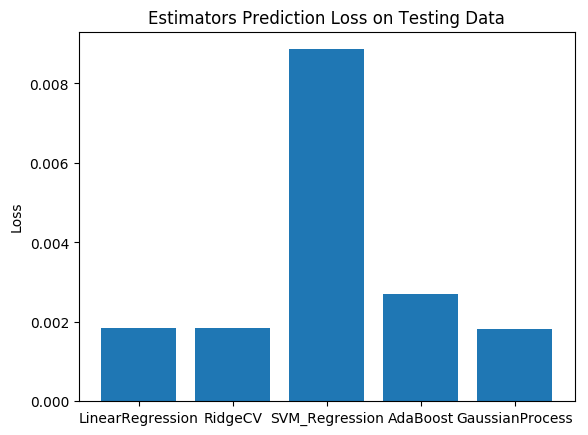

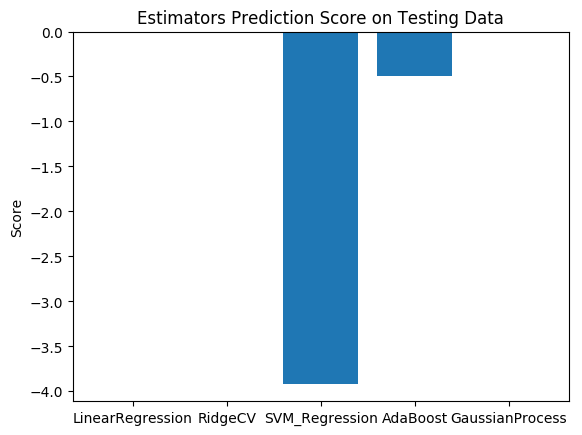

In [0]:
ESTIMATORS_NAME = ('LinearRegression', 'RidgeCV', 'SVM_Regression', 'AdaBoost', 'GaussianProcess')
y_pos = np.arange(len(ESTIMATORS_NAME))
 
plt.bar(y_pos, estimator_loss, align='center', alpha=1)
plt.xticks(y_pos, ESTIMATORS_NAME)
plt.ylabel('Loss')
plt.title('Estimators Prediction Loss on Testing Data')
plt.show()

plt.bar(y_pos, estimator_score, align='center', alpha=1)
plt.xticks(y_pos, ESTIMATORS_NAME)
plt.ylabel('Score')
plt.title('Estimators Prediction Score on Testing Data')
plt.show()

## Winner of Regression Model: RidgeCV regressor.
### As we can see above, we plotted the bar graphs for each model and their prediction score and least square loss. The score is the higher the better; the loss is the less the better(minimum is zero). Therefore, the model with the highest score and lowest loss is RigeCV regressor.

## 2.5 Define a collection of classification models and choose the best one.




In [0]:
# Define the features and labels.
input_data = normalised_data[["age", "gender", "interest1", "interest2", "interest3"]]

output_data = normalised_data[["approved_conversion"]]

# Since it is an classification task, we need to change the approved_conversion to binary value.
output_data.is_copy = False
output_data.loc[output_data.approved_conversion > 0, 'approved_conversion'] = 1
output_data.loc[output_data.approved_conversion <= 0, 'approved_conversion'] = 0
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

classifier_names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


## Visualise classification results.



In [0]:
 # iterate over classifiers
accuracy = []
prediction = []
conf_matrix = []
for name, clf in zip(classifier_names, classifiers):
    clf.fit(x_train, y_train.values.ravel())
    score = clf.score(x_test, y_test.values.ravel())
    y_pred = clf.predict(x_test);
    cm = confusion_matrix(y_test.values.ravel(), y_pred)
    conf_matrix.append(cm)
    prediction.append(y_pred)
    accuracy.append(score)
    print('Classifier Name:', name)
    print('Score:', score)
    print('*****************************************')

Classifier Name: Nearest Neighbors
Score: 0.5327510917030568
*****************************************
Classifier Name: Linear SVM
Score: 0.5021834061135371
*****************************************
Classifier Name: RBF SVM
Score: 0.5414847161572053
*****************************************
Classifier Name: Gaussian Process
Score: 0.5021834061135371
*****************************************
Classifier Name: Decision Tree
Score: 0.47161572052401746
*****************************************
Classifier Name: Random Forest
Score: 0.5851528384279476
*****************************************
Classifier Name: Neural Net
Score: 0.5764192139737991
*****************************************
Classifier Name: AdaBoost
Score: 0.5327510917030568
*****************************************
Classifier Name: Naive Bayes
Score: 0.5720524017467249
*****************************************
Classifier Name: QDA
Score: 0.5414847161572053
*****************************************


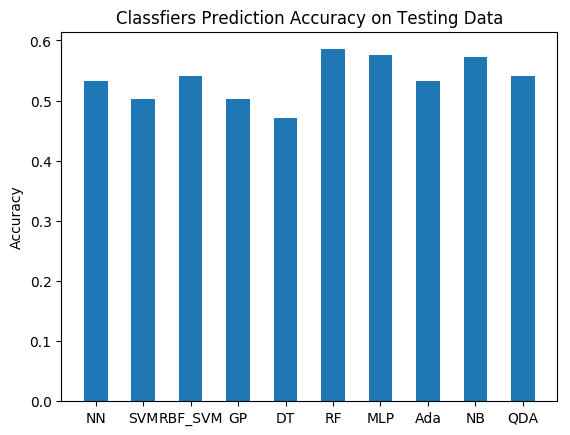

In [0]:
y_position = np.arange(len(classifier_names))

names = ["NN", "SVM", "RBF_SVM", "GP",
         "DT", "RF", "MLP", "Ada",
         "NB", "QDA"]
plt.bar(y_position, accuracy, align='center', alpha=1,width=0.5)
plt.xticks(y_position,names)
plt.ylabel('Accuracy')
plt.title('Classfiers Prediction Accuracy on Testing Data')
plt.show()

## 2.6 Choose the best classification model.
### 1. Plot the confusion matrix of the top three classification models, calculate the precision and recall for each of them.
2. Since we have limited budget and we only want to spent money for the right person, so the precision is the most important factor, which means the selected people are more possible to be our target user. Therefore, we can choose the model with the highest prescion.

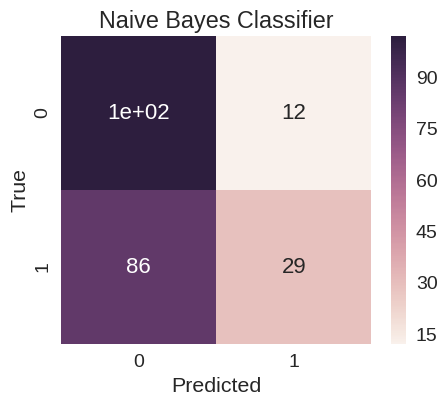

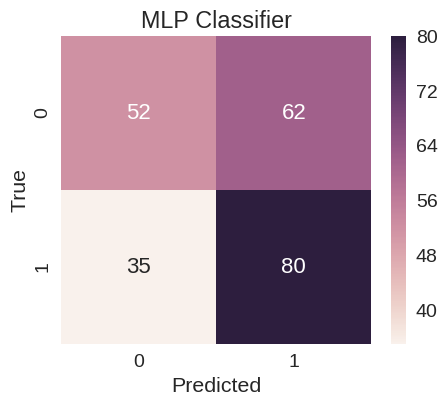

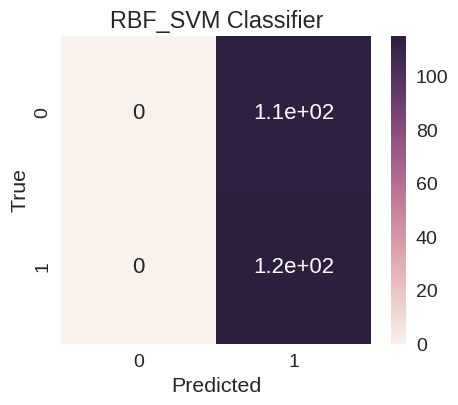

In [0]:

def plot_confusion_matrix(cm,title):
  df_cm = pd.DataFrame(cm, range(2),
                    range(2))
  plt.figure(figsize = (5,4))
  sn.set(font_scale=1.4)#for label size
  ax=sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
  ax.set_title(title)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')

# Plot confusion matrix of Naive Bayes Classifier.
plot_confusion_matrix(conf_matrix[8],'Naive Bayes Classifier')

# Plot confusion matrix of MLP Classifier.
plot_confusion_matrix(conf_matrix[6],'MLP Classifier')

# Plot confusion matrix of RBF_SVM Classifier.
plot_confusion_matrix(conf_matrix[1],'RBF_SVM Classifier')

## Winner of Classification Model: Naive Bayes Classifier
### As we can see above, the precision of Naive Bayes Classifier is about 0.71, for MLP is 0.56, for RBF_SVM is 0.50. Therefore, the winner is Naive Bayes Classifier.

## 6. Conclusion.
### In this assignment, I provide two approaches to optimize our bidding strategy. One is to use regression models to predict the ROI(return of investment) based on the user's profile; another approach is to use a classification model to classify our target customers. 

### In practice, two approaches can be combined to find an optimal credit assignment given a finite budget. For example,  given a collection of candidate users and their profile, we can use classification model to filter out the non-target users first, then we can use a regression model to predict the ROI for each target user. Finally, we can sort the target users based on their ROI value and choose the top n users for our advertisement campaign. 

### By doing that, we can reduce a considerable amount of unnecessary cost by selecting the most suitable users. Therefore, we implicitly optimized our bidding strategy. However, if we need to predict the best price for bidding in the campaign, we can train a regression model to predict the money we should spend on each selected user. I didn't implement such a model here because that required much more historical dataset and parameter-tunning to build a usable model. If you are interested, I am looking forward to discussing it with you in the next interview.

### Thanks for reviewing my code, I am enjoying this assignment because I feel excited to find useful patterns of data by using machine learning techniques( using sk-learn libraries actually). Since I am just a beginner in data science so I might make some obvious mistakes somewhere, if you have any suggestions, please don't hesitate to tell me so I can do a better job next time. (liang.huang@student.uva.nl).